In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm


In [11]:
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)


In [12]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI', 'BTC']
tickers

['SPY', 'BND', 'GLD', 'QQQ', 'VTI', 'BTC']

In [13]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Adj Close']

print(adj_close_df)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                   SPY        BND         GLD         QQQ         VTI   BTC
Date                                                                       
2009-08-13   76.815041  50.855007   93.720001   35.030495   39.008472   NaN
2009-08-14   76.225151  51.011192   93.000000   34.628563   38.651367   NaN
2009-08-17   74.349586  51.154465   91.610001   33.623692   37.648403   NaN
2009-08-18   74.939461  51.082848   92.059998   34.104286   38.043518   NaN
2009-08-19   75.597466  51.141445   92.529999   34.340225   38.370247   NaN
...                ...        ...         ...         ...         ...   ...
2024-08-02  532.900024  74.410004  225.339996  448.750000  262.899994  5.56
2024-08-05  517.380005  74.339996  222.479996  435.369995  255.179993  4.75
2024-08-06  522.150024  73.879997  220.699997  439.529999  257.769989  5.05
2024-08-07  518.659973  73.699997  220.550003  434.769989  255.800003  4.86
2024-08-08  530.650024  73.589996  224.009995  448.070007  261.790009  5.27

[3772 rows 

In [14]:
# Calculate the daily log returns and drop any NAs
# .shift(1) gives us our daily returns by taking the stock price divided by the previous days return
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns  = log_returns.dropna()

print(log_returns)

                 SPY       BND       GLD       QQQ       VTI       BTC
Date                                                                  
2024-08-01 -0.014262  0.003731 -0.003449 -0.024520 -0.015790 -0.029801
2024-08-02 -0.018794  0.011353 -0.001906 -0.024021 -0.020332 -0.010734
2024-08-05 -0.029556 -0.000941 -0.012773 -0.030270 -0.029805 -0.157453
2024-08-06  0.009177 -0.006207 -0.008033  0.009510  0.010099  0.061244
2024-08-07 -0.006706 -0.002439 -0.000680 -0.010889 -0.007672 -0.038350
2024-08-08  0.022854 -0.001494  0.015566  0.030132  0.023147  0.080992


In [22]:
### Create a function that will be used to calculate portfolio expected return
#We are assuming that future returns are based on past returns, which is not a reliable assumption.
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)


In [23]:
### Create a function that will be used to calculate portfolio standard deviation
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [25]:
### Create a covariance matrix for all the securities
cov_matrix = log_returns.cov()
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI       BTC
SPY  0.000370 -0.000058  0.000136  0.000447  0.000382  0.001473
BND -0.000058  0.000038  0.000003 -0.000076 -0.000063 -0.000086
GLD  0.000136  0.000003  0.000093  0.000165  0.000136  0.000550
QQQ  0.000447 -0.000076  0.000165  0.000559  0.000464  0.001682
VTI  0.000382 -0.000063  0.000136  0.000464  0.000395  0.001507
BTC  0.001473 -0.000086  0.000550  0.001682  0.001507  0.007220


In [26]:
### Create an equally weighted portfolio and find total portfolio expected return and standard deviation
portfolio_value = 1000000

#Create an equally weighted portfolio
weights = np.array([1/len(tickers)]*len(tickers))

portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation (weights, cov_matrix)

In [27]:
def random_z_score():
    return np.random.normal(0, 1)

### Create a function to calculate scenarioGainLoss
days = 20

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

In [29]:
### Run 10000 simulations
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

In [30]:
### Specify a confidence interval and calculate the Value at Risk (VaR)
confidence_interval = 0.99
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(VaR)

378605.7951178163


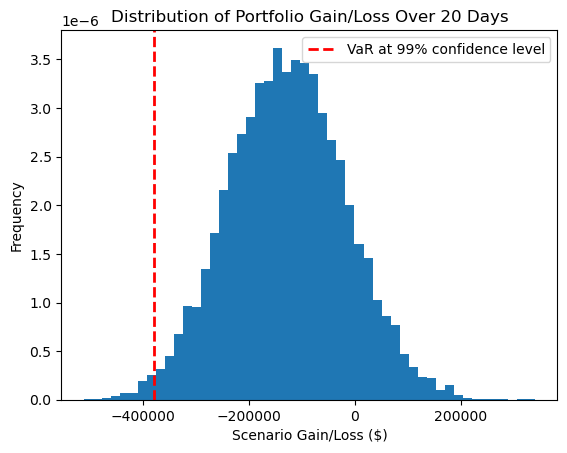

In [31]:
### Plot the results of all 10000 scenarios
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()